In [3]:
import numpy as np
import pandas as pd
from pyomo.environ import *
from pyomo.opt import SolverFactory
import random

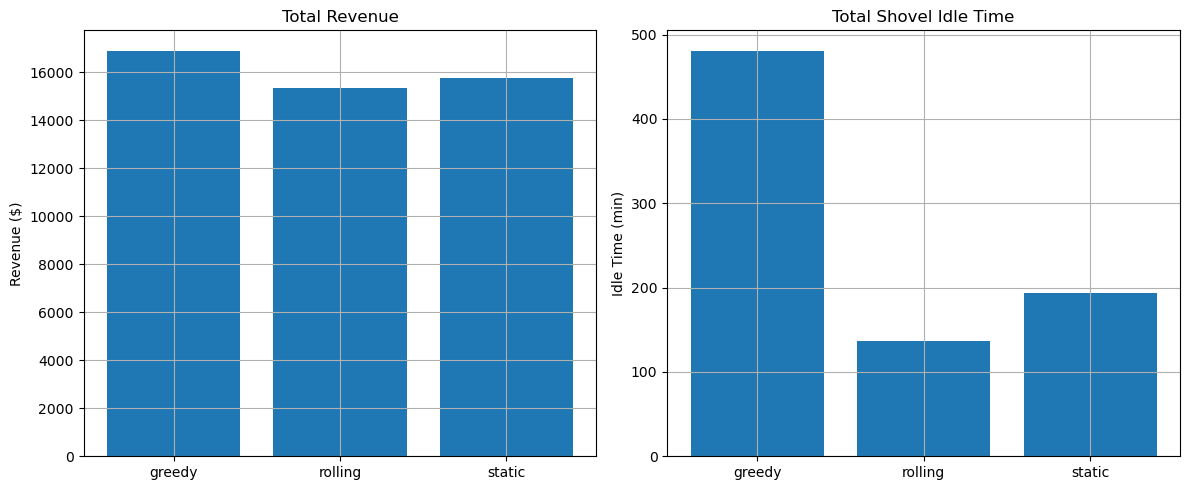

\n--- Revenue by Strategy ---
Strategy
greedy     16900
rolling    15340
static     15760
Name: Revenue, dtype: int64
\n--- Shovel Idle Time ---
Strategy
greedy     481
rolling    137
static     194
Name: IdleTime, dtype: int64


In [12]:
# Generate a clean complete script with rolling-horizon MIP dispatch, static and greedy baselines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *

# Configuration
SIM_DURATION = 480
NUM_TRUCKS = 10
MAX_QUEUE = 3
REVENUE = {'A': 100, 'B': 60}
SEED = 42
np.random.seed(SEED)

# Scenario definitions
SCENARIOS = {
    'fast': {'travel_factor': 0.8, 'load_factor': 0.8, 'prob': 0.3},
    'normal': {'travel_factor': 1.0, 'load_factor': 1.0, 'prob': 0.4},
    'slow': {'travel_factor': 1.2, 'load_factor': 1.2, 'prob': 0.3}
}

# Time parameters
TIME_PARAMS = {
    'travel_to': {'A': (10, 1), 'B': (7, 0.7)},
    'load': {'A': (4, 0.4), 'B': (4, 0.4)},
    'return_from': {'A': (15, 1.5), 'B': (11, 1.1)},
}

def generate_time(mean, std, scale=1.0):
    return max(0.1, np.random.normal(loc=mean * scale, scale=std))

def sample_scenario():
    names = list(SCENARIOS.keys())
    probs = [SCENARIOS[k]['prob'] for k in names]
    return np.random.choice(names, p=probs)

# Truck and shovel classes
class Truck:
    def __init__(self, id):
        self.id = id
        self.available_at = 0
        self.log = []

class Shovel:
    def __init__(self, id):
        self.id = id
        self.busy_until = 0
        self.queue = []
        self.idle_time = 0

# MIP dispatcher
def solve_dispatch_mip(truck_ids, queue_state, scenario):
    model = ConcreteModel()
    model.T = Set(initialize=truck_ids)
    model.S = Set(initialize=['A', 'B'])

    travel_factor = SCENARIOS[scenario]['travel_factor']
    load_factor = SCENARIOS[scenario]['load_factor']
    cycle_time = {
        s: TIME_PARAMS['travel_to'][s][0] * travel_factor +
           TIME_PARAMS['load'][s][0] * load_factor +
           TIME_PARAMS['return_from'][s][0]
        for s in model.S
    }

    model.x = Var(model.T, model.S, domain=Binary)
    model.obj = Objective(
        expr=sum(model.x[t, s] * (REVENUE[s] / cycle_time[s]) for t in model.T for s in model.S),
        sense=maximize
    )

    model.assign = Constraint(model.T, rule=lambda m, t: sum(m.x[t, s] for s in m.S) <= 1)
    model.queue_rem = Param(model.S, initialize={s: MAX_QUEUE - queue_state.get(s, 0) for s in model.S}, mutable=True)
    model.qlimit = Constraint(model.S, rule=lambda m, s: sum(m.x[t, s] for t in m.T) <= m.queue_rem[s])

    opt = SolverFactory('glpk', executable='/opt/homebrew/bin/glpsol')
    opt.solve(model, tee=False)

    return {
        t: next((s for s in model.S if value(model.x[t, s]) > 0.5), None)
        for t in model.T
    }

# Simulation loop
def simulate_dispatch(strategy):
    trucks = [Truck(i) for i in range(NUM_TRUCKS)]
    shovels = {'A': Shovel('A'), 'B': Shovel('B')}
    time = 0
    log = []

    while time <= SIM_DURATION:
        scenario = sample_scenario()
        travel_factor = SCENARIOS[scenario]['travel_factor']
        load_factor = SCENARIOS[scenario]['load_factor']
        queue_state = {s: len(shovels[s].queue) for s in shovels}
        available_trucks = [t for t in trucks if t.available_at <= time]

        if strategy == 'rolling':
            assignment = solve_dispatch_mip([t.id for t in available_trucks], queue_state, scenario)

        for truck in available_trucks:
            if strategy == 'static':
                dest = 'A' if truck.id < 7 else 'B'
            elif strategy == 'greedy':
                dest = 'A'
            elif strategy == 'rolling':
                dest = assignment.get(truck.id)
                if dest is None:
                    continue
            else:
                continue

            tt = generate_time(*TIME_PARAMS['travel_to'][dest], travel_factor)
            lt = generate_time(*TIME_PARAMS['load'][dest], load_factor)
            rt = generate_time(*TIME_PARAMS['return_from'][dest])
            duration = tt + lt + rt
            truck.available_at = time + duration
            truck.log.append((time, dest, REVENUE[dest], duration))
            log.append((time, truck.id, dest, REVENUE[dest], duration))

            shovel = shovels[dest]
            if shovel.busy_until <= time:
                shovel.busy_until = time + lt
            else:
                shovel.queue.append((time, lt))

        # Update shovel busy state and idle time
        for s in shovels.values():
            if s.busy_until <= time and not s.queue:
                s.idle_time += 1
            elif s.busy_until <= time and s.queue:
                _, lt = s.queue.pop(0)
                s.busy_until = time + lt

        time += 1

    df = pd.DataFrame(log, columns=['Time', 'Truck', 'Shovel', 'Revenue', 'Duration'])
    idle_df = pd.DataFrame([{'Shovel': s.id, 'IdleTime': s.idle_time} for s in shovels.values()])
    return df, idle_df

# Run and compare all strategies
strategies = ['static', 'greedy', 'rolling']
all_dfs = []
idle_summaries = []

for strat in strategies:
    df, idle = simulate_dispatch(strat)
    df['Strategy'] = strat
    all_dfs.append(df)
    idle['Strategy'] = strat
    idle_summaries.append(idle)

combined_df = pd.concat(all_dfs)
combined_idle = pd.concat(idle_summaries)

# Plotting
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
rev_summary = combined_df.groupby('Strategy')['Revenue'].sum()
axs[0].bar(rev_summary.index, rev_summary.values)
axs[0].set_title("Total Revenue")
axs[0].set_ylabel("Revenue ($)")
axs[0].grid(True)

idle_summary = combined_idle.groupby('Strategy')['IdleTime'].sum()
axs[1].bar(idle_summary.index, idle_summary.values)
axs[1].set_title("Total Shovel Idle Time")
axs[1].set_ylabel("Idle Time (min)")
axs[1].grid(True)

plt.tight_layout()
plt.show()

print("\\n--- Revenue by Strategy ---")
print(rev_summary)
print("\\n--- Shovel Idle Time ---")
print(idle_summary)



In [14]:
combined_df.groupby(['Strategy'])['Duration'].describe()
#combined_df.groupby(['Strategy', 'Shovel']).count()


,count,mean,std,min,25%,50%,75%,max
Strategy,,,,,,,,
greedy,169.0,28.985435,2.660004,22.736424,27.332485,28.910526,30.801389,34.611550
rolling,185.0,26.087620,4.639228,16.016425,22.443973,26.144508,29.867992,35.129572
static,184.0,26.103348,4.335889,17.799035,22.537483,25.843965,29.403134,36.242403


In [15]:
combined_df.groupby(['Strategy', 'Shovel']).count()


Time  Truck  Revenue  Duration
Strategy Shovel                                
greedy   A        169    169      169       169
rolling  A        106    106      106       106
         B         79     79       79        79
static   A        118    118      118       118
         B         66     66       66        66

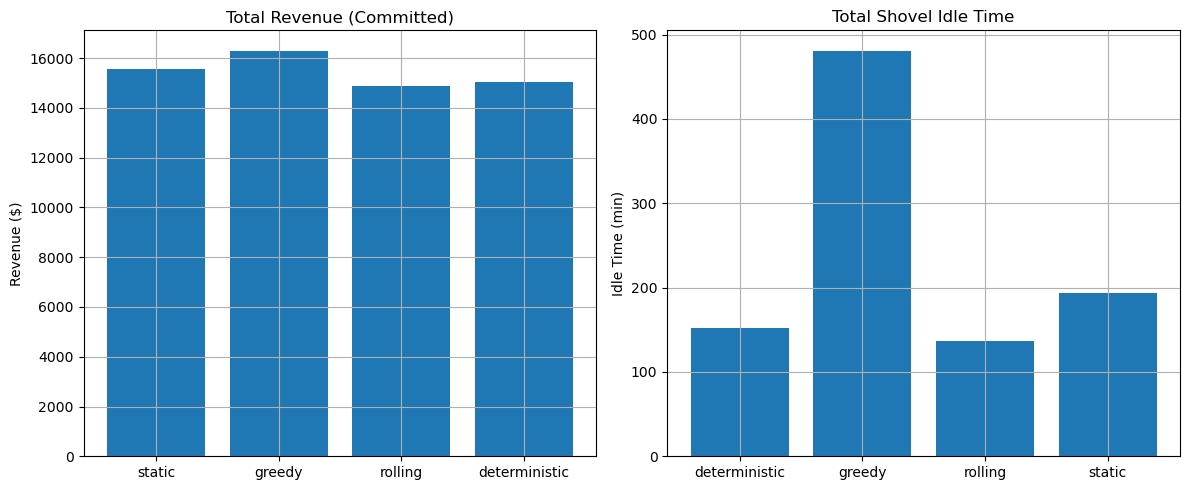

\n--- Revenue by Strategy (Committed Trips) ---
static           15560
greedy           16300
rolling          14860
deterministic    15020
dtype: int64
\n--- Shovel Idle Time ---
Strategy
deterministic    152
greedy           481
rolling          137
static           194
Name: IdleTime, dtype: int64


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *

# Configuration
SIM_DURATION = 480
NUM_TRUCKS = 10
MAX_QUEUE = 3
REVENUE = {'A': 100, 'B': 60}
SEED = 42
np.random.seed(SEED)

SCENARIOS = {
    'fast': {'travel_factor': 0.8, 'load_factor': 0.8, 'prob': 0.3},
    'normal': {'travel_factor': 1.0, 'load_factor': 1.0, 'prob': 0.4},
    'slow': {'travel_factor': 1.2, 'load_factor': 1.2, 'prob': 0.3}
}

TIME_PARAMS = {
    'travel_to': {'A': (10, 1), 'B': (7, 0.7)},
    'load': {'A': (4, 0.4), 'B': (4, 0.4)},
    'return_from': {'A': (15, 1.5), 'B': (11, 1.1)},
}

def generate_time(mean, std, scale=1.0):
    return max(0.1, np.random.normal(loc=mean * scale, scale=std))

def sample_scenario():
    names = list(SCENARIOS.keys())
    probs = [SCENARIOS[k]['prob'] for k in names]
    return np.random.choice(names, p=probs)

class Truck:
    def __init__(self, id):
        self.id = id
        self.available_at = 0
        self.log = []
        self.committed = False
        self.commit_revenue = 0

class Shovel:
    def __init__(self, id):
        self.id = id
        self.busy_until = 0
        self.queue = []
        self.idle_time = 0

# Update the script to add a 'deterministic' MIP strategy using nominal parameters

#--- Deterministic MIP Dispatcher ---
def solve_deterministic_mip(truck_ids, queue_state):
    model = ConcreteModel()
    model.T = Set(initialize=truck_ids)
    model.S = Set(initialize=['A', 'B'])

    travel_factor = 1.0
    load_factor = 1.0
    cycle_time = {
        s: TIME_PARAMS['travel_to'][s][0] * travel_factor +
           TIME_PARAMS['load'][s][0] * load_factor +
           TIME_PARAMS['return_from'][s][0]
        for s in model.S
    }

    model.x = Var(model.T, model.S, domain=Binary)
    model.obj = Objective(
        expr=sum(model.x[t, s] * (REVENUE[s] / cycle_time[s]) for t in model.T for s in model.S),
        sense=maximize
    )

    model.assign = Constraint(model.T, rule=lambda m, t: sum(m.x[t, s] for s in m.S) <= 1)
    model.queue_rem = Param(model.S, initialize={s: MAX_QUEUE - queue_state.get(s, 0) for s in model.S}, mutable=True)
    model.qlimit = Constraint(model.S, rule=lambda m, s: sum(m.x[t, s] for t in m.T) <= m.queue_rem[s])

    opt = SolverFactory('glpk', executable='/opt/homebrew/bin/glpsol')
    opt.solve(model, tee=False)

    return {
        t: next((s for s in model.S if value(model.x[t, s]) > 0.5), None)
        for t in model.T
    }


def solve_dispatch_mip(truck_ids, queue_state, scenario):
    model = ConcreteModel()
    model.T = Set(initialize=truck_ids)
    model.S = Set(initialize=['A', 'B'])

    travel_factor = SCENARIOS[scenario]['travel_factor']
    load_factor = SCENARIOS[scenario]['load_factor']
    cycle_time = {
        s: TIME_PARAMS['travel_to'][s][0] * travel_factor +
           TIME_PARAMS['load'][s][0] * load_factor +
           TIME_PARAMS['return_from'][s][0]
        for s in model.S
    }

    model.x = Var(model.T, model.S, domain=Binary)
    model.obj = Objective(
        expr=sum(model.x[t, s] * (REVENUE[s] / cycle_time[s]) for t in model.T for s in model.S),
        sense=maximize
    )

    model.assign = Constraint(model.T, rule=lambda m, t: sum(m.x[t, s] for s in m.S) <= 1)
    model.queue_rem = Param(model.S, initialize={s: MAX_QUEUE - queue_state.get(s, 0) for s in model.S}, mutable=True)
    model.qlimit = Constraint(model.S, rule=lambda m, s: sum(m.x[t, s] for t in m.T) <= m.queue_rem[s])

    opt = SolverFactory('glpk', executable='/opt/homebrew/bin/glpsol')
    opt.solve(model, tee=False)

    return {
        t: next((s for s in model.S if value(model.x[t, s]) > 0.5), None)
        for t in model.T
    }

def simulate_dispatch(strategy):
    trucks = [Truck(i) for i in range(NUM_TRUCKS)]
    shovels = {'A': Shovel('A'), 'B': Shovel('B')}
    time = 0
    log = []

    while time <= SIM_DURATION:
        scenario = sample_scenario()
        travel_factor = SCENARIOS[scenario]['travel_factor']
        load_factor = SCENARIOS[scenario]['load_factor']
        queue_state = {s: len(shovels[s].queue) for s in shovels}
        available_trucks = [t for t in trucks if t.available_at <= time]

        if strategy == 'rolling':
            assignment = solve_dispatch_mip([t.id for t in available_trucks], queue_state, scenario)

        for truck in available_trucks:
            if strategy == 'static':
                dest = 'A' if truck.id < 7 else 'B'
            elif strategy == 'greedy':
                dest = 'A'
            elif strategy == 'rolling':
                dest = assignment.get(truck.id)
                if dest is None:
                    continue
            elif strategy == 'deterministic':
                assignment = solve_deterministic_mip([t.id for t in available_trucks], queue_state)
                dest = assignment.get(truck.id)
                if dest is None:
                    continue
            else:
                continue


            tt = generate_time(*TIME_PARAMS['travel_to'][dest], travel_factor)
            lt = generate_time(*TIME_PARAMS['load'][dest], load_factor)
            rt = generate_time(*TIME_PARAMS['return_from'][dest])
            duration = tt + lt + rt
            truck.available_at = time + duration
            truck.log.append((time, dest, REVENUE[dest], duration))
            log.append((time, truck.id, dest, REVENUE[dest], duration))

            # Mark as committed if hauling begins before SIM_DURATION
            if time + tt + lt <= SIM_DURATION:
                truck.committed = True
                truck.commit_revenue += REVENUE[dest]

            shovel = shovels[dest]
            if shovel.busy_until <= time:
                shovel.busy_until = time + lt
            else:
                shovel.queue.append((time, lt))

        for s in shovels.values():
            if s.busy_until <= time and not s.queue:
                s.idle_time += 1
            elif s.busy_until <= time and s.queue:
                _, lt = s.queue.pop(0)
                s.busy_until = time + lt

        time += 1

    df = pd.DataFrame(log, columns=['Time', 'Truck', 'Shovel', 'Revenue', 'Duration'])
    idle_df = pd.DataFrame([{'Shovel': s.id, 'IdleTime': s.idle_time} for s in shovels.values()])
    committed_revenue = sum(t.commit_revenue for t in trucks)
    return df, idle_df, committed_revenue

# Run and compare
strategies = ['static', 'greedy', 'rolling', 'deterministic']
all_dfs = []
idle_summaries = []
revenues = {}

for strat in strategies:
    df, idle, commit_revenue = simulate_dispatch(strat)
    df['Strategy'] = strat
    all_dfs.append(df)
    idle['Strategy'] = strat
    idle_summaries.append(idle)
    revenues[strat] = commit_revenue

combined_df = pd.concat(all_dfs)
combined_idle = pd.concat(idle_summaries)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
rev_series = pd.Series(revenues)
axs[0].bar(rev_series.index, rev_series.values)
axs[0].set_title("Total Revenue (Committed)")
axs[0].set_ylabel("Revenue ($)")
axs[0].grid(True)

idle_summary = combined_idle.groupby('Strategy')['IdleTime'].sum()
axs[1].bar(idle_summary.index, idle_summary.values)
axs[1].set_title("Total Shovel Idle Time")
axs[1].set_ylabel("Idle Time (min)")
axs[1].grid(True)

plt.tight_layout()
plt.show()

print("\\n--- Revenue by Strategy (Committed Trips) ---")
print(rev_series)
print("\\n--- Shovel Idle Time ---")
print(idle_summary)

In [24]:
combined_df.groupby(['Strategy'])['Duration'].describe()

,count,mean,std,min,25%,50%,75%,max
Strategy,,,,,,,,
deterministic,183.0,26.328009,4.112080,17.059340,23.383906,26.618710,29.753612,34.496439
greedy,169.0,28.985435,2.660004,22.736424,27.332485,28.910526,30.801389,34.611550
rolling,185.0,26.087620,4.639228,16.016425,22.443973,26.144508,29.867992,35.129572
static,184.0,26.103348,4.335889,17.799035,22.537483,25.843965,29.403134,36.242403


In [23]:
combined_df.groupby(['Strategy', 'Shovel']).count()

Time  Truck  Revenue  Duration
Strategy      Shovel                                
deterministic A        110    110      110       110
              B         73     73       73        73
greedy        A        169    169      169       169
rolling       A        106    106      106       106
              B         79     79       79        79
static        A        118    118      118       118
              B         66     66       66        66